# Journal Recommendation - Figure Generator

In [1]:
from collections import Counter
import itertools
import os
from pathlib import Path
import pickle
import random
import sys

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from tqdm import tqdm

import plotnine as p9

In [ ]:
sys.path.append(str(Path("..").resolve()))
from SAUCIE import SAUCIE, Loader  # noqa: E402
import tensorflow.compat.v1 as tf  # noqa: E402

In [2]:
# Set up porting from python to R
# and R to python :mindblown:

import rpy2.rinterface  # noqa: E402

%load_ext rpy2.ipython

# Plot Accuracy Results

In [3]:
results = [
    {
        "value": 0.00522 / 0.00522,
        "model": "random_baseline",
        "distance": "N/A",
        "dataset": "train (cross validation)",
    },
    {
        "value": 0.39457 / 0.00517,
        "model": "paper_paper",
        "distance": "euclidean",
        "dataset": "train (cross validation)",
    },
    {
        "value": 0.35982 / 0.00517,
        "model": "centroid",
        "distance": "euclidean",
        "dataset": "train (cross validation)",
    },
    {
        "value": 0.39824 / 0.00517,
        "model": "paper_paper",
        "distance": "manhattan",
        "dataset": "train (cross validation)",
    },
    {
        "value": 0.39824 / 0.00517,
        "model": "centroid",
        "distance": "manhattan",
        "dataset": "train (cross validation)",
    },
    {
        "value": 0.01506 / 0.01506,
        "model": "random_baseline",
        "distance": "N/A",
        "dataset": "test",
    },
    {
        "value": 0.15317 / 0.01506,
        "model": "paper_paper",
        "distance": "euclidean",
        "dataset": "test",
    },
    {
        "value": 0.17347 / 0.01506,
        "model": "centroid",
        "distance": "euclidean",
        "dataset": "test",
    },
    {
        "value": 0.20380 / 0.01506,
        "model": "paper_paper",
        "distance": "manhattan",
        "dataset": "test",
    },
    {
        "value": 0.21523 / 0.01506,
        "model": "centroid",
        "distance": "manhattan",
        "dataset": "test",
    },
]

In [4]:
result_df = pd.DataFrame.from_records(results)

result_df["dataset"] = pd.Categorical(
    result_df.dataset.tolist(), categories=["train (cross validation)", "test"]
)

result_df.head()

,value,model,distance,dataset
0,1.000000,random_baseline,N/A,train (cross validation)
1,76.319149,paper_paper,euclidean,train (cross validation)
2,69.597679,centroid,euclidean,train (cross validation)
3,77.029014,paper_paper,manhattan,train (cross validation)
4,77.029014,centroid,manhattan,train (cross validation)


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/knn_result.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.66 x 5 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/knn_result.png


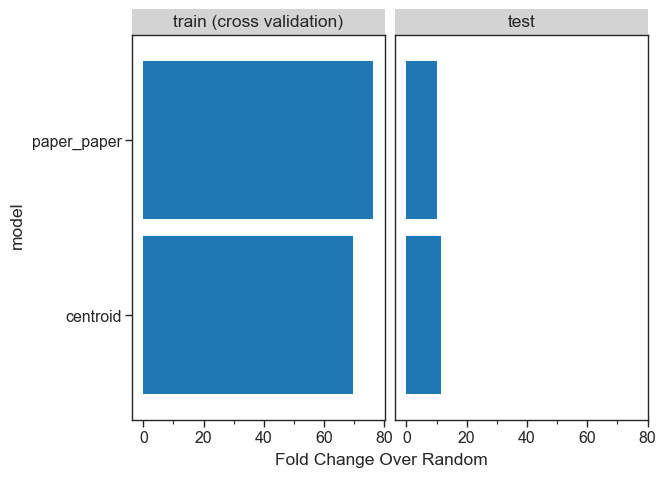

<ggplot: (8758988491384)>


In [5]:
g = (
    p9.ggplot(
        result_df.query("distance in ['euclidean']").rename(
            index=str, columns={"value": "fold_change"}
        ),
        p9.aes(x="model", y="fold_change"),
    )
    + p9.geom_col(position="dodge", show_legend=False, fill="#1f78b4")
    + p9.coord_flip()
    + p9.facet_wrap("dataset")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=1.3)
    + p9.theme(figure_size=(6.66, 5))
    + p9.labs(y="Fold Change Over Random", fill="Distance Metric")
)

g.save(Path("output") / Path("figures") / Path("knn_result.svg"))

g.save(Path("output") / Path("figures") / Path("knn_result.png"), dpi=250)

print(g)

# Generate 2D Visualization

## Use SAUCIE on PMC

### Set Up Grid Evaluation

In [6]:
# Set the seeds to fix the reproducebility issue
def set_seeds():
    np.random.seed(100)
    tf.reset_default_graph()
    tf.set_random_seed(seed=100)
    os.environ["PYTHONHASHSEED"] = str(100)
    random.seed(100)

In [7]:
def run_saucie_param_grid(
    dataset,
    learning_rate_grid=[1e-3],
    lambda_c_grid=[0],
    lambda_d_grid=[0],
    steps_grid=[1000],
):
    plot_df = pd.DataFrame(
        [], columns=["dim1", "dim2", "lambda_c", "lambda_d", "journal"]
    )

    hyper_param_grid = itertools.product(
        learning_rate_grid, lambda_c_grid, lambda_d_grid, steps_grid
    )

    for learning_rate, lambda_c, lambda_d, steps in tqdm(hyper_param_grid):

        set_seeds()

        saucie = SAUCIE(
            dataset.shape[1] - 2,
            lambda_b=0,
            lambda_c=lambda_c,
            lambda_d=lambda_d,
            learning_rate=learning_rate,
            save_folder="output/model",
        )

        loadtrain = Loader(
            dataset.drop(["journal", "document"], axis=1).values,
            pd.Categorical(dataset["journal"].values).codes,
            shuffle=True,
        )

        saucie.train(loadtrain, steps=steps)

        loadeval = Loader(
            dataset.drop(["journal", "document"], axis=1).values,
            pd.Categorical(dataset["journal"].values).codes,
            shuffle=False,
        )

        embedding = saucie.get_embedding(loadeval)

        plot_df = plot_df.append(
            pd.DataFrame(embedding[0], columns=["dim1", "dim2"]).assign(
                steps=steps,
                learning_rate=learning_rate,
                lambda_c=lambda_c,
                lambda_d=lambda_d,
                journal=dataset.journal.tolist(),
            )
        )

    return plot_df

### Load the data

In [8]:
full_paper_dataset = pd.read_csv(
    Path("output/paper_dataset") / Path("paper_dataset_full.tsv.xz"), sep="\t"
)
print(full_paper_dataset.shape)
full_paper_dataset.head()

(1809901, 302)


,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.168362,0.044431,-0.068592,-0.025250,-0.638518,-0.302347,0.303967,-0.122796,...,0.012046,-0.156143,0.010454,-0.615891,-0.952055,-0.504918,0.113741,0.763464,-0.789372,0.009379
1,Environ_Health,PMC1226148,-0.239919,-0.060203,-0.133328,0.360897,-0.517385,-0.249687,0.056513,0.052408,...,0.321736,-0.251242,0.261475,-0.577342,-0.544784,-0.484138,0.065360,0.530282,-0.828810,-0.012625
2,Environ_Health,PMC5635510,0.048672,0.170688,-0.070395,0.236424,-0.039087,-0.381143,0.051673,-0.148415,...,0.097997,-0.170264,0.064343,-0.447883,-0.758610,-0.459414,0.433691,0.676709,-0.573157,-0.104958
3,Environ_Health,PMC3125232,-0.186567,0.081031,-0.073595,-0.137754,0.068354,-0.406180,-0.219826,-0.108129,...,-0.090546,-0.173788,0.071811,-0.444737,-0.949252,-0.587158,0.341312,0.888989,-0.476960,-0.284114
4,Environ_Health,PMC3533997,-0.064178,0.173903,-0.051677,0.159768,-0.305409,-0.493326,0.267089,-0.005127,...,-0.075961,-0.404060,-0.012403,-0.567062,-1.054321,-0.372887,0.075409,0.681162,-0.849728,-0.233986


In [9]:
journal_counts = full_paper_dataset.journal.value_counts()
journal_counts[journal_counts > 1000][-4:]

Stem_Cell_Reports         1025
Front_Public_Health       1024
Pharmacogn_Mag            1021
Mol_Ther_Nucleic_Acids    1019
Name: journal, dtype: int64

In [10]:
full_paper_dataset_subset = full_paper_dataset.query(
    "journal in " f"{journal_counts[journal_counts > 1000][-4:].index.tolist()}"
)
full_paper_dataset_subset.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
64245,Pharmacogn_Mag,PMC4189264,0.240253,-0.152448,-0.362718,0.409180,-0.378141,-0.364913,-0.181714,0.059308,...,0.409049,-0.492930,0.480093,-0.451878,-0.105443,-0.174803,-0.059366,0.225128,-0.875468,0.269184
64246,Pharmacogn_Mag,PMC4189284,0.395407,0.111727,-0.409769,-0.024531,-0.441155,-0.460752,-0.127751,0.237699,...,0.562072,-0.135963,0.235963,-0.632726,-0.390934,-0.111200,-0.108823,0.177248,-0.840145,0.573707
64247,Pharmacogn_Mag,PMC5307912,0.015072,-0.017692,-0.066243,-0.002101,-0.418130,0.012797,0.002181,0.118348,...,0.276591,-0.195047,0.271879,-0.546798,-0.496170,-0.246271,-0.037871,0.418199,-0.672914,0.495734
64248,Pharmacogn_Mag,PMC5858244,-0.019564,-0.252580,-0.139097,0.365929,-0.428957,-0.152773,-0.059261,0.217141,...,0.329100,-0.348712,0.312069,-0.374694,-0.254673,-0.149876,0.027304,0.455275,-0.563752,0.436166
64249,Pharmacogn_Mag,PMC4791998,0.202603,-0.012224,-0.321510,0.334807,-0.551659,-0.321583,0.089906,0.156017,...,0.617878,-0.304669,0.245924,-0.696464,-0.289285,-0.473836,-0.179085,0.470209,-0.968208,0.366259


### Evaluate the Grid

This section involves tuning the hyperparameters of the SAUCIE network. This network sues a shallow autoencoder to project high dimensional data into a low dimensional space. This network takes in three lambda parameters along with a learning rate and number of steps. The plots in this section show the results of different parameters being tunes on a small subset of PMC papers (randomly sampled from four different journals). The best parameters for this model separates the four journals into their own distinct clusters.

In [11]:
lambda_c_grid = np.linspace(1e-6, 1, num=5)
lambda_d_grid = np.linspace(1e-6, 1, num=5)

In [12]:
set_seeds()
plot_df = run_saucie_param_grid(
    full_paper_dataset_subset, lambda_c_grid=lambda_c_grid, lambda_d_grid=lambda_d_grid
)

0it [00:00, ?it/s]


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.



Instructions for updating:
keep_dims is deprecated, use keepdims instead



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








25it [05:23, 12.93s/it]


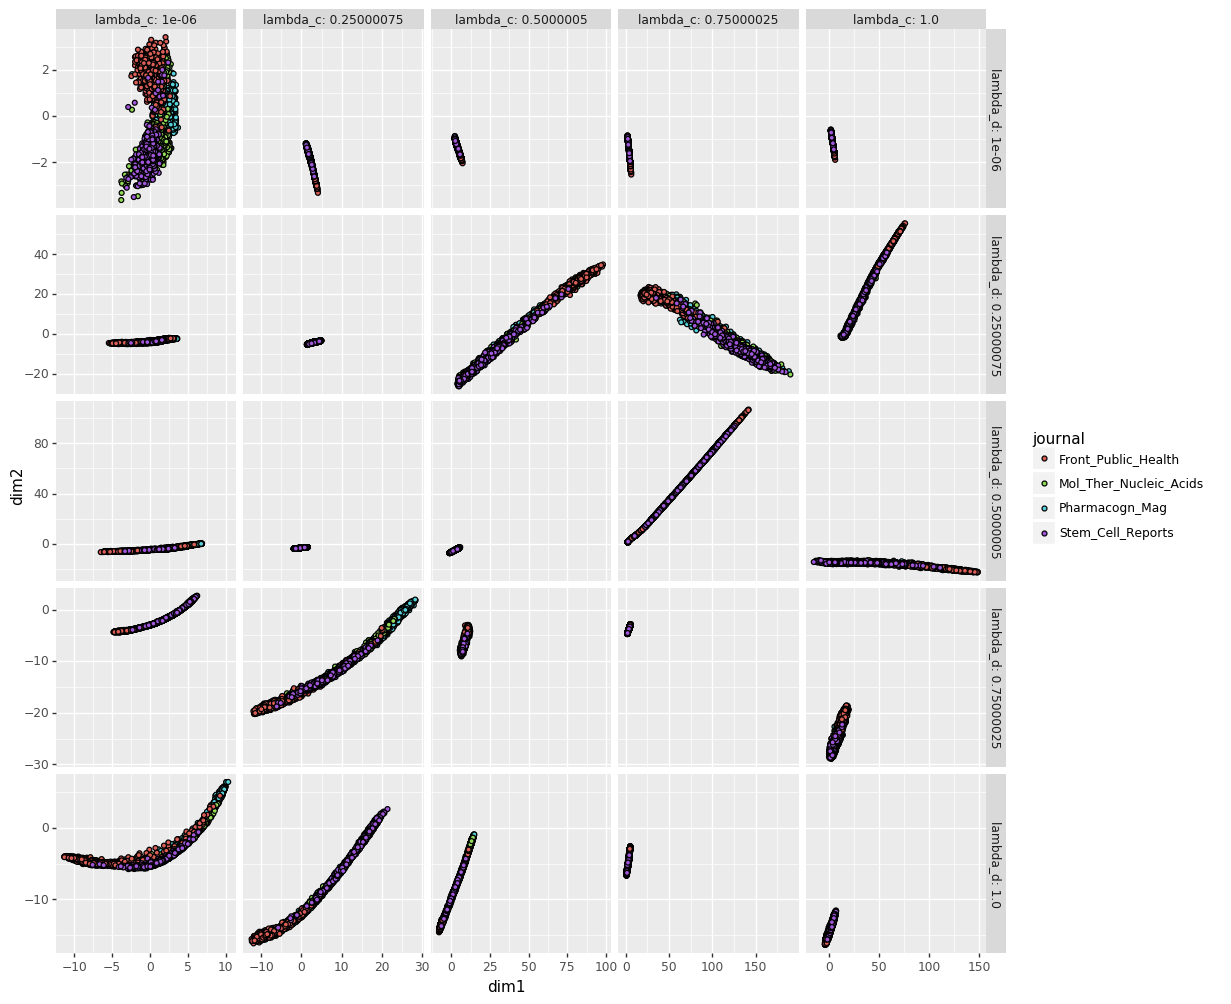

<ggplot: (-9223363277878915973)>


In [13]:
g = (
    p9.ggplot(plot_df)
    + p9.aes(x="dim1", y="dim2", fill="journal")
    + p9.facet_grid("lambda_d ~ lambda_c", labeller="label_both", scales="free")
    + p9.geom_point()
    + p9.theme(figure_size=(12, 12))
)
print(g)

In [14]:
lambda_c_grid = np.linspace(1e-6, 1e-3, num=5)
lambda_d_grid = np.linspace(1e-6, 1e-3, num=5)

In [15]:
plot_df = run_saucie_param_grid(
    full_paper_dataset_subset, lambda_c_grid=lambda_c_grid, lambda_d_grid=lambda_d_grid
)

25it [05:23, 12.93s/it]


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 12 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/saucie_hyperparam_lambda_cd.png


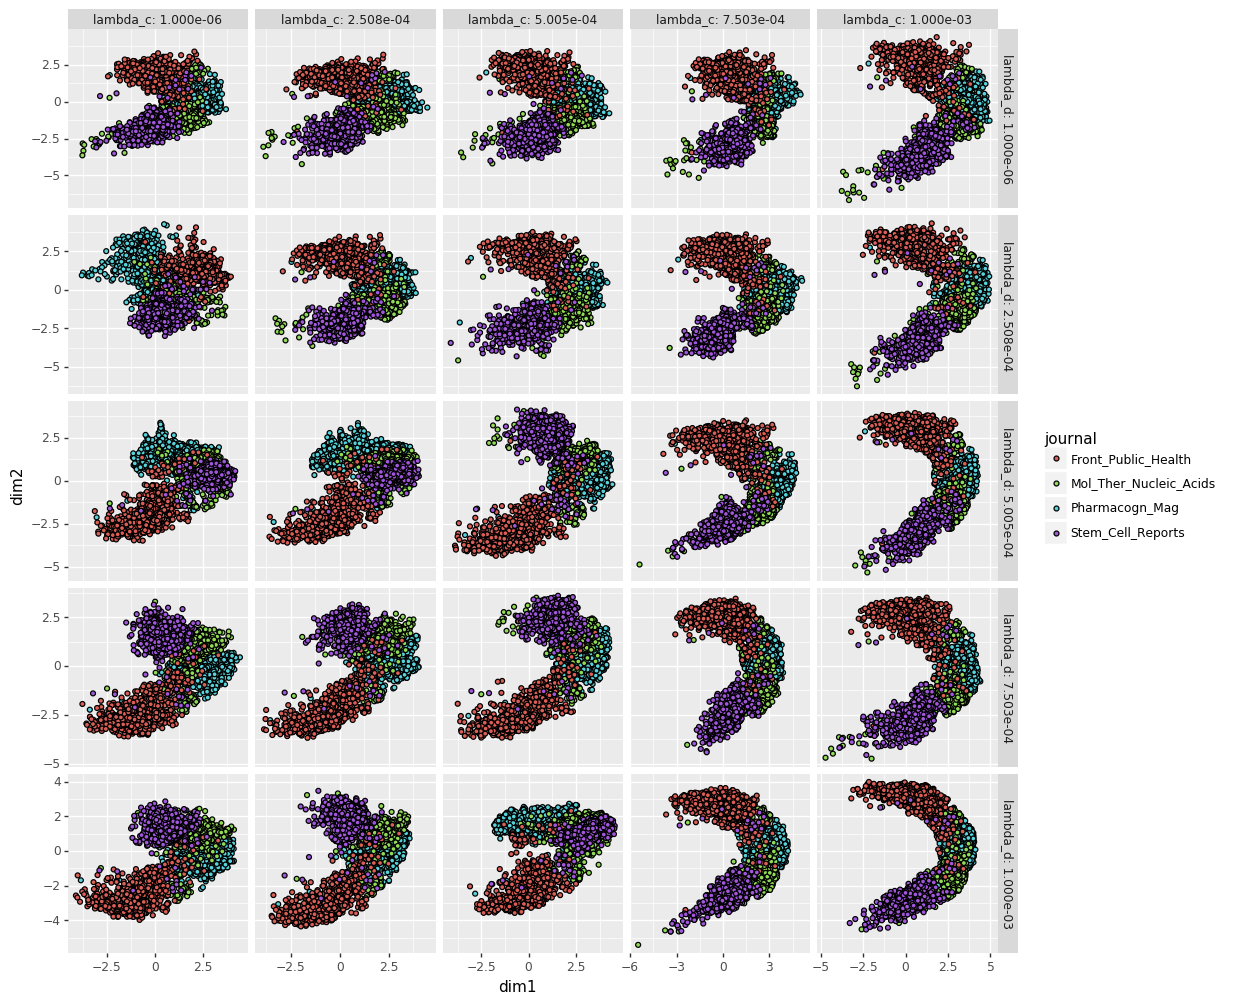

<ggplot: (8758981071792)>


In [16]:
g = (
    p9.ggplot(plot_df)
    + p9.aes(x="dim1", y="dim2", fill="journal")
    + p9.facet_grid(
        "lambda_d ~ lambda_c",
        labeller=p9.labeller(
            cols=lambda s: f"lambda_c: {float(s):.3e}",
            rows=lambda s: f"lambda_d: {float(s):.3e}",
        ),
        scales="free",
    )
    + p9.geom_point()
    + p9.theme(figure_size=(12, 12))
)
g.save("output/figures/saucie_hyperparam_lambda_cd.png", dpi=500)
print(g)

In [17]:
learning_rate_grid = np.linspace(1e-6, 1e-3, num=3)
steps_grid = [1000, 3000, 5000, 10000, 10000]

In [18]:
plot_df = run_saucie_param_grid(
    full_paper_dataset_subset,
    lambda_c_grid=[1.000e-3],
    lambda_d_grid=[1.000e-3],
    steps_grid=steps_grid,
    learning_rate_grid=learning_rate_grid,
)

15it [17:41, 70.80s/it]


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 12 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/saucie_hyperparam_lr_steps.png


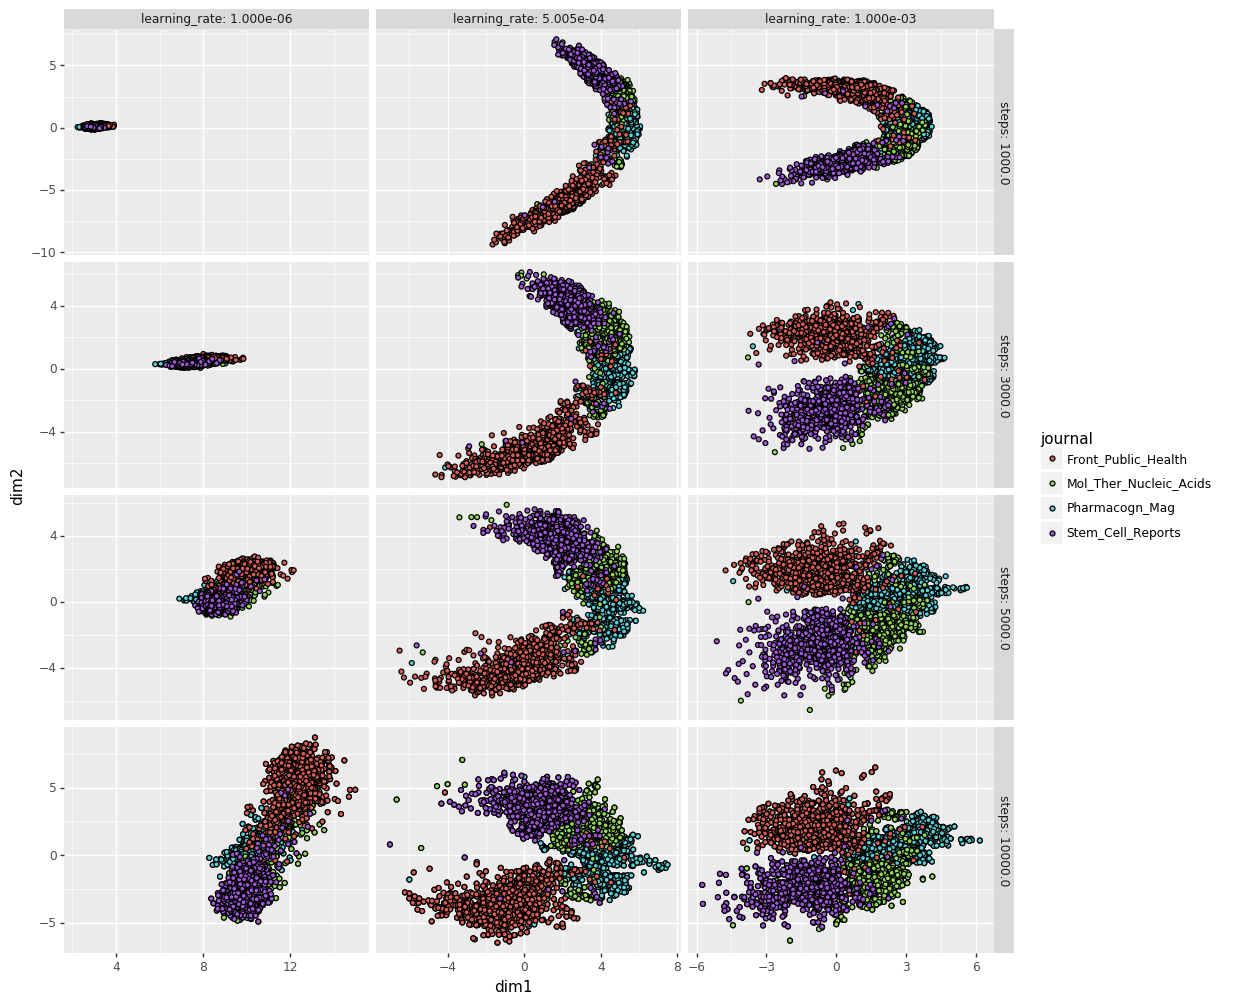

<ggplot: (-9223363277876763858)>


In [19]:
g = (
    p9.ggplot(plot_df)
    + p9.aes(x="dim1", y="dim2", fill="journal")
    + p9.facet_grid(
        "steps ~ learning_rate",
        labeller=p9.labeller(
            cols=lambda s: f"learning_rate: {float(s):.3e}",
            rows=lambda s: f"steps: {s}",
        ),
        scales="free",
    )
    + p9.geom_point()
    # + p9.scale_fill_discrete(guide=False)
    + p9.theme(figure_size=(12, 12))
)
g.save("output/figures/saucie_hyperparam_lr_steps.png", dpi=500)
print(g)

In [20]:
set_seeds()

saucie = SAUCIE(
    full_paper_dataset.shape[1] - 2,
    lambda_b=0,
    lambda_c=1e-3,
    lambda_d=1e-3,
    learning_rate=1e-3,
    save_folder="output/model",
)

loadtrain = Loader(
    full_paper_dataset.drop(["journal", "document"], axis=1).values,
    pd.Categorical(full_paper_dataset["journal"].values).codes,
    shuffle=True,
)

saucie.train(loadtrain, steps=5000)
saucie.save()

loadeval = Loader(
    full_paper_dataset.drop(["journal", "document"], axis=1).values,
    pd.Categorical(full_paper_dataset["journal"].values).codes,
    shuffle=False,
)
embedding = saucie.get_embedding(loadeval)
embedding

Model saved to output/model/SAUCIE


(array([[ 0.7506782 ,  2.2532103 ],
        [ 1.2789867 ,  0.23426728],
        [ 1.4673212 ,  2.1773267 ],
        ...,
        [-4.784562  ,  2.825874  ],
        [-4.232069  ,  4.627819  ],
        [-5.14812   ,  4.4215426 ]], dtype=float32),
 array([662, 662, 662, ..., 477, 477, 477], dtype=int16))

In [21]:
full_dataset = pd.DataFrame(embedding[0], columns=["dim1", "dim2"]).assign(
    journal=full_paper_dataset.journal.tolist(),
    document=full_paper_dataset.document.tolist(),
)
print(full_dataset.shape)

full_dataset.to_csv(
    Path("output/paper_dataset") / Path("paper_dataset_full_tsne.tsv"),
    sep="\t",
    index=False,
)

full_dataset.head()

(1809901, 4)


,dim1,dim2,journal,document
0,0.750678,2.253210,Environ_Health,PMC1552054
1,1.278987,0.234267,Environ_Health,PMC1226148
2,1.467321,2.177327,Environ_Health,PMC5635510
3,1.437781,3.523604,Environ_Health,PMC3125232
4,0.926364,2.067309,Environ_Health,PMC3533997


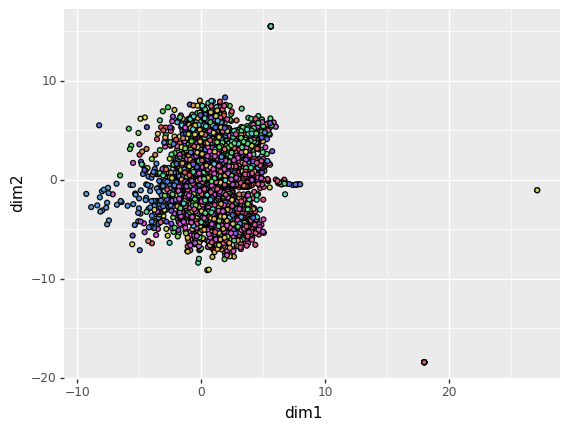

<ggplot: (-9223363277875138353)>


In [22]:
g = (
    p9.ggplot(full_dataset.sample(10000, random_state=100))
    + p9.aes(x="dim1", y="dim2", fill="journal")
    + p9.geom_point()
    + p9.scale_fill_discrete(guide=False)
)
print(g)

# Generate Bin plots

## Square Plot

In [23]:
data_df = pd.read_csv(
    Path("output") / Path("paper_dataset") / Path("paper_dataset_full_tsne.tsv"),
    sep="\t",
)
print(data_df.shape)
data_df.head()

(1809901, 4)


,dim1,dim2,journal,document
0,0.750678,2.253210,Environ_Health,PMC1552054
1,1.278987,0.234267,Environ_Health,PMC1226148
2,1.467321,2.177327,Environ_Health,PMC5635510
3,1.437781,3.523604,Environ_Health,PMC3125232
4,0.926364,2.067309,Environ_Health,PMC3533997


In [24]:
data_df.describe()

,dim1,dim2
count,1.809901e+06,1.809901e+06
mean,8.153906e-01,5.203515e-01
std,1.763486e+00,2.434616e+00
min,-1.407040e+01,-1.841692e+01
25%,-1.843799e-01,-5.779626e-01
50%,6.812124e-01,4.312767e-01
75%,1.707367e+00,1.873336e+00
max,2.712325e+01,1.552628e+01


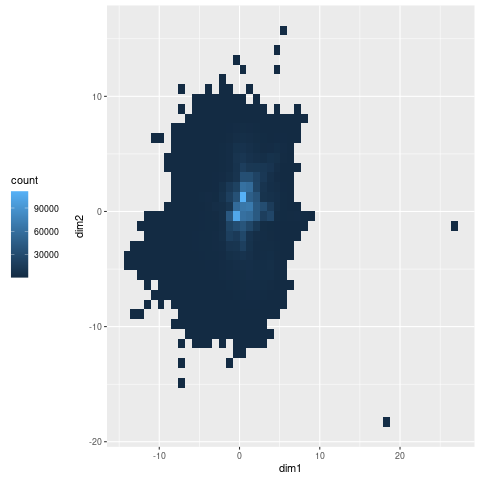

In [25]:
%%R -i data_df -o square_plot_df

library(ggplot2)

bin_width = 0.85
g <- (
    ggplot(data_df, aes(x=dim1, y=dim2))

In [ ]:
# )
# square_plot_df <- ggplot_build(g)$data[[1]]

In [26]:
print(square_plot_df.shape)  # noqa: F821
square_plot_df.head()  # noqa: F821

(512, 22)


,fill,xbin,ybin,value,x,y,count,ncount,density,ndensity,...,xmin,xmax,ymin,ymax,colour,size,linetype,alpha,width,height
1,#142D46,39,1,2044.0,18.275,-18.275,2044.0,0.018318,1.129344e-03,0.018318,...,17.85,1.870000e+01,-18.70,-17.85,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648
2,#132B43,9,5,2.0,-7.225,-14.875,2.0,0.000018,1.105033e-06,0.000018,...,-7.65,-6.800000e+00,-15.30,-14.45,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648
3,#132B43,9,7,1.0,-7.225,-13.175,1.0,0.000009,5.525164e-07,0.000009,...,-7.65,-6.800000e+00,-13.60,-12.75,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648
4,#132B43,16,7,1.0,-1.275,-13.175,1.0,0.000009,5.525164e-07,0.000009,...,-1.70,-8.499999e-01,-13.60,-12.75,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648
5,#132B43,17,8,2.0,-0.425,-12.325,2.0,0.000018,1.105033e-06,0.000018,...,-0.85,8.500000e-08,-12.75,-11.90,-2147483648,0.1,1.0,-2147483648,-2147483648,-2147483648


In [27]:
full_paper_dataset = pd.read_csv(
    Path("output/paper_dataset") / Path("paper_dataset_full.tsv.xz"), sep="\t"
)
print(full_paper_dataset.shape)
full_paper_dataset.head()

(1809901, 302)


,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.168362,0.044431,-0.068592,-0.025250,-0.638518,-0.302347,0.303967,-0.122796,...,0.012046,-0.156143,0.010454,-0.615891,-0.952055,-0.504918,0.113741,0.763464,-0.789372,0.009379
1,Environ_Health,PMC1226148,-0.239919,-0.060203,-0.133328,0.360897,-0.517385,-0.249687,0.056513,0.052408,...,0.321736,-0.251242,0.261475,-0.577342,-0.544784,-0.484138,0.065360,0.530282,-0.828810,-0.012625
2,Environ_Health,PMC5635510,0.048672,0.170688,-0.070395,0.236424,-0.039087,-0.381143,0.051673,-0.148415,...,0.097997,-0.170264,0.064343,-0.447883,-0.758610,-0.459414,0.433691,0.676709,-0.573157,-0.104958
3,Environ_Health,PMC3125232,-0.186567,0.081031,-0.073595,-0.137754,0.068354,-0.406180,-0.219826,-0.108129,...,-0.090546,-0.173788,0.071811,-0.444737,-0.949252,-0.587158,0.341312,0.888989,-0.476960,-0.284114
4,Environ_Health,PMC3533997,-0.064178,0.173903,-0.051677,0.159768,-0.305409,-0.493326,0.267089,-0.005127,...,-0.075961,-0.404060,-0.012403,-0.567062,-1.054321,-0.372887,0.075409,0.681162,-0.849728,-0.233986


In [28]:
pca_components_df = pd.read_csv(
    Path("../../biorxiv")
    / Path("pca_association_experiment")
    / Path("output")
    / Path("word_pca_similarity")
    / Path("pca_components.tsv"),
    sep="\t",
)
print(pca_components_df.shape)
pca_components_df.head()

(50, 300)


,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,-0.049104,-0.022952,0.054169,0.054761,0.035576,-0.010399,-0.024812,-0.048933,0.017739,0.088210,...,-0.074235,-0.055353,-0.008411,0.026470,-0.026992,-0.032384,0.035687,0.070615,-0.018170,-0.097132
1,-0.025294,0.025114,0.044676,-0.124849,-0.057298,0.006263,0.074133,0.061397,-0.021857,-0.091527,...,-0.007480,0.028617,-0.049084,0.024782,-0.013106,-0.007171,0.008073,0.068401,0.101262,0.096735
2,0.034591,0.073876,0.081714,-0.064158,-0.041002,0.021764,0.103048,-0.014965,0.015615,0.116552,...,-0.013544,0.064324,-0.055909,-0.069447,-0.112860,-0.091762,0.000651,0.036475,0.057296,-0.083348
3,-0.049435,-0.079498,0.022533,0.082681,-0.078703,-0.024764,0.031693,0.042404,-0.034200,0.026995,...,-0.001326,-0.103326,0.053888,-0.101415,0.046668,-0.087855,-0.108510,0.035366,-0.099735,-0.005285
4,-0.089308,0.008366,-0.053669,-0.040672,0.089469,0.001333,-0.082718,-0.011179,0.005334,-0.017407,...,0.053544,-0.001412,0.052857,0.052416,-0.038935,-0.116536,-0.033255,0.131235,0.050803,-0.013997


In [29]:
mapped_data_df = pd.DataFrame([], columns=data_df.columns.tolist() + ["squarebin_id"])
square_bin_records = []

for idx, (row_idx, square_bin) in tqdm(
    enumerate(square_plot_df.iterrows())  # noqa: F821
):

    top_left = (square_bin["xmin"], square_bin["ymax"])
    bottom_right = (square_bin["xmax"], square_bin["ymin"])

    datapoints_df = data_df.query(
        f"dim1 > {top_left[0]} and dim1 < {bottom_right[0]}"
    ).query(f"dim2 < {top_left[1]} and dim2 > {bottom_right[1]}")

    # sanity check that I'm getting the coordinates correct
    assert datapoints_df.shape[0] == square_bin["count"]

    bin_pca_dist = 1 - cdist(
        pca_components_df,
        (
            full_paper_dataset.query(f"document in {datapoints_df.document.tolist()}")
            .drop(["journal", "document"], axis=1)
            .mean(axis=0)
            .values[:, np.newaxis]
            .T
        ),
        "cosine",
    )

    pca_sim_df = pd.DataFrame(
        {
            "score": bin_pca_dist[:, 0],
            "pc": [f"0{dim+1}" if dim + 1 < 10 else f"{dim+1}" for dim in range(50)],
        }
    )

    pca_sim_df = pca_sim_df.reindex(
        pca_sim_df.score.abs().sort_values(ascending=False).index
    )

    square_bin_records.append(
        {
            "x": square_bin["x"],
            "y": square_bin["y"],
            "xmin": square_bin["xmin"],
            "xmax": square_bin["xmax"],
            "ymin": square_bin["ymin"],
            "ymax": square_bin["ymax"],
            "count": datapoints_df.shape[0],
            "bin_id": idx,
            "pc": pca_sim_df.to_dict(orient="records"),
            "journal": dict(Counter(datapoints_df.journal.tolist()).items()),
        }
    )

    mapped_data_df = mapped_data_df.append(
        datapoints_df.assign(squarebin_id=idx).reset_index(drop=True), ignore_index=True
    )

512it [02:35,  3.29it/s]


In [30]:
mapped_data_df.head()

,dim1,dim2,journal,document,squarebin_id
0,18.007381,-18.416918,Med_Hist_Suppl,PMC2557413,0
1,18.007381,-18.416918,Med_Hist_Suppl,PMC2530993,0
2,18.007381,-18.416918,Med_Hist_Suppl,PMC2557483,0
3,18.007381,-18.416918,Med_Hist_Suppl,PMC2642002,0
4,18.007381,-18.416918,Med_Hist_Suppl,PMC2530995,0


In [ ]:
print(mapped_data_df.shape)
mapped_data_df.to_csv(
    Path("output") / Path("paper_dataset") / Path("paper_dataset_tsne_square.tsv"),
    sep="\t",
    index=False,
)

In [ ]:
square_map_df = pd.DataFrame.from_records(square_bin_records)
square_map_df.head()

In [ ]:
square_map_df.to_json(
    Path("output") / Path("app_plots") / Path("pmc_square_plot.json"),
    orient="records",
    lines=False,
)